In [1]:
pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 1.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.7/655.7 kB 3.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=05e276af2e6a3650f6217a855934c3675adf79a9134fe3071017233527da14cf
  Stored in directory: /Users/omkarkalekar/Library/Caches/pip/wheels/5f/d4/d7/4189b07b5902ee9f3ce0dbb14909fbe8037c39d6c63ffd49c9
Successfully built htmlmin
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

In [9]:
data = pd.read_csv('/Users/omkarkalekar/Downloads/red_wine.csv')
df = pd.DataFrame(data, columns=["citric acid", "sulphates", "alcohol", "type"])
print(df)

     citric acid  sulphates  alcohol  type
0           0.49       0.63      8.0   low
1           0.66       0.57      8.3   low
2           0.23       0.44      8.5  high
3           0.44       0.84      8.6   low
4           0.08       0.50      8.7   low
..           ...        ...      ...   ...
566         0.40       0.70     12.7   low
567         0.28       0.60     12.8  high
568         0.31       0.60     12.8  high
569         0.34       0.72     12.8   low
570         0.35       0.32     12.8  high

[571 rows x 4 columns]


In [11]:
profile = ProfileReport(df, title="Profiling Report", explorative = True)
profile.to_file("red_wine_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 450.66it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
import joblib

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [15]:
red_wine = pd.read_csv('/Users/omkarkalekar/Downloads/red_wine.csv')
# Encode target variable
label_encoder = LabelEncoder()
red_wine["type"] = label_encoder.fit_transform(red_wine["type"])

# Split features and target variable
X_red = red_wine.drop(columns=["type"])
y_red = red_wine["type"]

#print the target value
print(y_red)

0      1
1      1
2      0
3      1
4      1
      ..
566    1
567    0
568    0
569    1
570    0
Name: type, Length: 571, dtype: int64


In [17]:
# Define 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

dummy_clf = DummyClassifier(strategy="most_frequent")
y_pred_dummy = cross_val_predict(dummy_clf, X_red, y_red, cv=cv, method="predict")
y_proba_dummy = cross_val_predict(dummy_clf, X_red, y_red, cv=cv, method="predict_proba")[:, 1]

# Computing baseline metrics
baseline_accuracy = accuracy_score(y_red, y_pred_dummy)
baseline_auc = roc_auc_score(y_red, y_proba_dummy)

# Storing baseline results
results2 = {"Model": ["Baseline"], "AUC": [baseline_auc], "Accuracy": [baseline_accuracy]}

In [19]:
 #---- Define Models ----
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM-Linear": SVC(kernel="linear", probability=True, random_state=42),
    "SVM-RBF": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# ---- Train Models, Evaluate with 10-Fold CV, and Save Weights ----
for model_name, model in models.items():
    # Train the model on full red wine dataset
    model.fit(X_red, y_red)
    
    # Save trained model weights
    joblib.dump(model, f"{model_name}1.pkl")

    # Evaluate using 10-fold CV
    y_pred = cross_val_predict(model, X_red, y_red, cv=cv, method="predict")
    y_proba = cross_val_predict(model, X_red, y_red, cv=cv, method="predict_proba")[:, 1]

    # Compute metrics
    acc = accuracy_score(y_red, y_pred)
    auc = roc_auc_score(y_red, y_proba)

    # Store results
    results2["Model"].append(model_name)
    results2["AUC"].append(auc)
    results2["Accuracy"].append(acc)

 # Store Random Forest probabilities for ROC curve
    if model_name == "Random Forest":
        random_forest_probs = y_proba
results_df_3 = pd.DataFrame(results2)
print(results_df_3)

                 Model       AUC  Accuracy
0             Baseline  0.500000  0.528897
1  Logistic Regression  0.873938  0.784588
2          Naive Bayes  0.890495  0.824869
3        Decision Tree  0.797416  0.798599
4           SVM-Linear  0.872677  0.793345
5              SVM-RBF  0.852981  0.535902
6        Random Forest  0.920764  0.840630


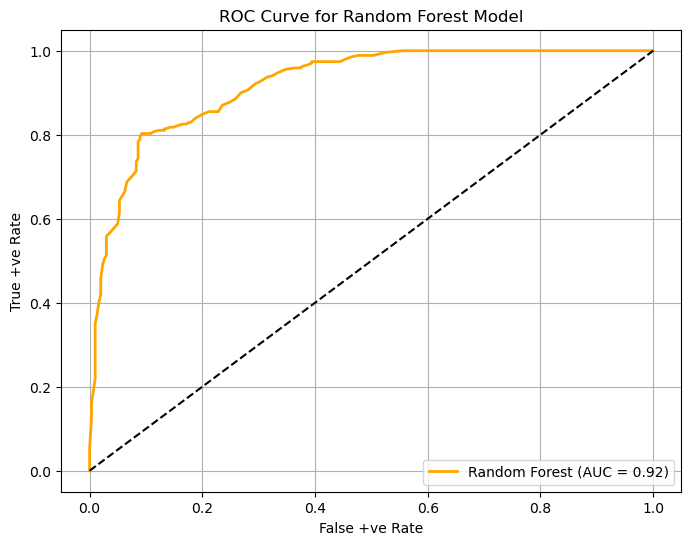

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline
# ---- Generate and Plot ROC Curve for Random Forest ----
if random_forest_probs is not None:
    fpr, tpr, _ = roc_curve(y_red, random_forest_probs)
    auc = roc_auc_score(y_red, random_forest_probs)  # Ensure AUC is calculated

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="orange", lw=2, label=f"Random Forest (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")  # Diagonal line (random model)
    plt.xlabel("False +ve Rate")
    plt.ylabel("True +ve Rate")
    plt.title("ROC Curve for Random Forest Model")
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.show(block=True)  # Forces the plot to display

In [29]:
# testing the pretrained random forest model on the white_wine.csv 

# Load best model 
best_model = joblib.load("Random Forest1.pkl")

# Load and preprocess white_wine.csv
white_wine = pd.read_csv("white_wine.csv")
white_wine["type"] = label_encoder.transform(white_wine["type"])
X_white = white_wine.drop(columns=["type"])
y_white = white_wine["type"]

# Make predictions on white wine dataset

y_proba_white = best_model.predict_proba(X_white)[:, 1]

auc_white = roc_auc_score(y_white, y_proba_white)

print(f"AUC on white wine dataset: {auc_white}")

AUC on white wine dataset: 0.9739633558341368


AUC on white wine dataset: 0.9488910318225652
